## Visualisation des données Air Pays de la Loire

Accèssibles sur leur site [this page](https://www.airpl.org/), les données mesurées concernent de nombreux polluants atmosphériques à des points précis de mesures des taux de concentration. 

Pour une première analyse, nous nous interessons aux concentrations en PM10 dans le departement Loire-Atlantique. Notre pas de mesure est d'une heure, et pour limiter le poids des données, nous nous concentrons sur une semaine (du 19/03/2023 au 25/03/2023)

D'abord, chargeons les données et observons-les

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import plotly.express as px
from pynsee.geodata import get_geodata_list, get_geodata

In [2]:
raw_df_PM10_hour_week = pd.read_csv(r'./PM10_horaire_semaine.csv', sep=';')
raw_df_PM10_hour_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nom_dept           1848 non-null   object 
 1   nom_com            1848 non-null   object 
 2   insee_com          1848 non-null   int64  
 3   nom_station        1848 non-null   object 
 4   code_station (ue)  1848 non-null   object 
 5   influence          1848 non-null   object 
 6   nom_poll           1848 non-null   object 
 7   id_poll_ue         1848 non-null   int64  
 8   valeur             1834 non-null   float64
 9   unite              1848 non-null   object 
 10  metrique           1848 non-null   object 
 11  date_debut         1848 non-null   object 
 12  date_fin           1848 non-null   object 
 13  statut_valid       1848 non-null   bool   
 14  x_wgs84            1848 non-null   float64
 15  y_wgs84            1848 non-null   float64
 16  x_reglementaire    1848 

On observe 18 colonnes décrivant nos data : 

- nom_dept : nom du département où se situe la station de mesure (issu des données de l’IGN).

- nom_com : nom de la commune où se situe la station de mesure (issu des données de l’IGN).

- insee_com : code INSEE de la commune où se situe la station de mesure (issu des données de l’IGN).

- nom_station : nom de la station de mesure déterminé par Air Pays de la Loire.

- code_station (ue) : code unique de la station de mesure.

- influence : nature de la station de mesure déterminée par sa localisation et son influence selon le type de polluant qu’elle mesure. 

- nom_poll : nom du polluant mesuré par la station de mesure.

- id_poll_ue : identifiant du polluant dans le référentiel européen.

- valeur : valeur de la mesure relevée pour un polluant à une station et à une métrique données.

- unite : unité de la valeur mesurée du polluant.

- metrique : niveau d’agrégation temporelle des données mesurées (horaire, journalière, mensuelle, annuelle).

- date_debut : date de début du relevé de mesure en heure temps local (heure sur le territoire métropolitain français).

- date_fin : date de fin du relevé de mesure en heure temps local (heure sur le territoire métropolitain français).

- statut_valid : validité de la mesure relevée, « t » si la mesure est validée, « f » si la mesure est invalidée.

- x_wgs84 : coordonnée x de la localisation de la station de mesure en World Geodetic System 1984

- y_wgs84 : coordonnée y de la localisation de la station de mesure en World Geodesic System 1984

- x_reglementaire : coordonnée x de la localisation de la station de mesure en Lambert 93 (EPSG : 2154).

- y_reglementaire : coordonnée y de la localisation de la station de mesure en Lambert 93 (EPSG : 2154).

In [3]:
raw_df_PM10_hour_week.head()

,nom_dept,nom_com,insee_com,nom_station,code_station (ue),influence,nom_poll,id_poll_ue,valeur,unite,metrique,date_debut,date_fin,statut_valid,x_wgs84,y_wgs84,x_reglementaire,y_reglementaire
0,Loire-Atlantique,Donges,44052,LA MEGRETAIS,FR23003,industrial,PM10,5,6.7,µg/m3,horaire,2023-03-25 22:00:00,2023-03-25 23:00:00,True,-2.039245,47.322705,319631.265310,6.703517e+06
1,Loire-Atlantique,Frossay,44061,FROSSAY,FR23068,industrial,PM10,5,2.7,µg/m3,horaire,2023-03-25 22:00:00,2023-03-25 23:00:00,True,-1.936524,47.247352,326851.682361,6.694673e+06
2,Loire-Atlantique,Saint-Etienne-De-Montluc,44158,SAINT ETIENNE DE MONTLUC,FR23070,industrial,PM10,5,11.0,µg/m3,horaire,2023-03-25 22:00:00,2023-03-25 23:00:00,True,-1.783081,47.283127,338676.423909,6.697926e+06
3,Loire-Atlantique,Nantes,44109,LA CHAUVINIERE,FR23107,background,PM10,5,5.7,µg/m3,horaire,2023-03-25 22:00:00,2023-03-25 23:00:00,True,-1.573275,47.252912,354313.235770,6.693636e+06
4,Loire-Atlantique,Saint-Nazaire,44184,LEON BLUM,FR23110,background,PM10,5,13.0,µg/m3,horaire,2023-03-25 22:00:00,2023-03-25 23:00:00,True,-2.250154,47.264110,303302.164390,6.698060e+06


# Preprocessing : 
On veut épurer le dataframe des colonnes qui ne nous interessent pas, et renommer certaines pour plus de facilité dans la manipulation

In [55]:
col_of_interess = ['nom_station', 'code_station (ue)', 'valeur', 'date_fin', 'statut_valid', 'x_wgs84', 'y_wgs84']
df_PM10_hour_week = raw_df_PM10_hour_week[col_of_interess]
df_PM10_hour_week = df_PM10_hour_week.rename(columns={'code_station (ue)': 'code_station', 'date_fin': 'heure_mesure', 'x_wgs84': 'long', 'y_wgs84': 'lat'})
df_PM10_hour_week['heure_mesure'] = pd.to_datetime(df_PM10_hour_week['heure_mesure'])
df_PM10_hour_week.head()

,nom_station,code_station,valeur,heure_mesure,statut_valid,long,lat
0,LA MEGRETAIS,FR23003,6.7,2023-03-25 23:00:00,True,-2.039245,47.322705
1,FROSSAY,FR23068,2.7,2023-03-25 23:00:00,True,-1.936524,47.247352
2,SAINT ETIENNE DE MONTLUC,FR23070,11.0,2023-03-25 23:00:00,True,-1.783081,47.283127
3,LA CHAUVINIERE,FR23107,5.7,2023-03-25 23:00:00,True,-1.573275,47.252912
4,LEON BLUM,FR23110,13.0,2023-03-25 23:00:00,True,-2.250154,47.264110


In [5]:
# y a t-il des lignes invalides ? 
invalid = df_PM10_hour_week['statut_valid'].value_counts()
print(invalid)

# TODO : les filtrer

statut_valid
True     1834
False      14
Name: count, dtype: int64


# Visualisation simple de chaque station sur la journée du 25/03/2023

In [66]:
df_PM10_25032023 = df_PM10_hour_week.loc[df_PM10_hour_week['heure_mesure'].dt.date == pd.to_datetime('2023-03-25')]
## ERROOR : Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. 
# In a future version these will be considered non-comparable. 
# Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
# a creuser... 

px.line(df_PM10_25032023,
        x='heure_mesure',
        y='valeur',
        color='nom_station',
        title='Evolution des valeurs de PM10 sur la journée du 25/03/2023 en Loire-Atlantique')


On observe comme prévu une augmentation de la concentration de PM10 pendant la journée, et une moindre concentration la nuit. 
La mesure des polluants dans l'air est lié à beaucoup de phénomène, et les évolutions (dont pics) peuvent s'expliquer par les conditions météo ou une intervention humaine particulière. 

Mais d'abord, où sont situées nos stations ? En les affichant avec plotly, nous allons observer leur valeur moyenne en PM10

In [7]:
df_localisation = df_PM10_hour_week[['nom_station', 'long', 'lat', 'valeur']]
df_localisation = df_localisation.groupby(['nom_station']).agg({'long': 'first', 'lat': 'first', 'valeur': 'mean'})
df_localisation.reset_index(inplace=True)

fig = px.scatter_mapbox(df_localisation,
                        lat='lat',
                        lon='long', 
                        hover_name='nom_station',
                        color='valeur',
                        size='valeur',
                        zoom=9,
                        height=400,
                        size_max=10,
                        opacity=0.9,
                        width=800
                        )
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
fig.update_layout(title_text="Localisation des stations avec leur valeur moyenne en PM10 sur la semaine du 19 au 25 mars 2023")
fig.show()


Il est interessant de suivre sur la semaine l'evolution de stations géographiquement proches : Trentemoult et les Couets. 

In [8]:
df_PM10_Trent_Couets = df_PM10_hour_week.loc[(df_PM10_hour_week['nom_station'] == 'LES COUETS') | (df_PM10_hour_week['nom_station'] == 'TRENTEMOULT')]

px.line(df_PM10_Trent_Couets,
        x='heure_mesure',
        y='valeur',
        color='nom_station',
        title='Evolution des valeurs de PM10 sur la semaine du 19/03/2023 au 25/03/2023 en Loire-Atlantique')

Les deux stations ont une évolution similaire, mais on peut noter quelques pics spcifiques : 
- le 20 mars entre 20h et 22h pour Trentemoult
- le 21 mars entre 15h et 17h pour les Couets

# Faire de la prediction à partir des données Air Pays de la Loire et météorologiques

Données accessibles : 
- ApdL = par heure sur les 11 stations, plusieurs polluants disponible
- SYNOP = historique des relevés météo de France (1 station a Bouguenais : pression, variation de pression, direction et vitesse du vent, T°, humidité...). Relevé toutes les 3h. https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?flg=fr&sort=date&refine.nom_dept=Loire-Atlantique&refine.date=2023
- MeteoFrance = modélisation fine sur toute la france, mais soumis a redevance. https://donneespubliques.meteofrance.fr/?fond=produit&id_produit=131&id_rubrique=51
- jeu de données MeteoNet = relevés sur 3 ans (2016-2018) dans la zone nord ouest (Nantes inclus). 218Gb mais divisble selon interet. https://meteonet.umr-cnrm.fr/

## Visualization of MeteoNet Data

I chose to use MeteoNet dataset for their accesibility and documentation available on their use. The North-West region (NW) of France englobe Loire-Atlantique department and a whole set of data is available : ground wheather stations reports, 2D and 3D weather models... for 2016, 2017, 2018.

The database is quite heavy : 
- NW_ground_stations_2018 = 174 Mo (tar.gz), 1.75 Go (.csv)
- NW_weather_models_2D_2018 = 7.4 Go (tar.gz)

To keep a reasonnable size and ease the process, we focus on base NW_ground_stations_2018 to download [here](https://www.kaggle.com/datasets/katerpillar/meteonet)

In [9]:
raw_df_nw2018 = pd.read_csv(r'./NW2018.csv', sep=',')
raw_df_nw2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22034571 entries, 0 to 22034570
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   number_sta  int64  
 1   lat         float64
 2   lon         float64
 3   height_sta  float64
 4   date        object 
 5   dd          float64
 6   ff          float64
 7   precip      float64
 8   hu          float64
 9   td          float64
 10  t           float64
 11  psl         float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.0+ GB


Description de notre set de données : 

- number_sta : ground station number

- lat : latitude into decimal degrees

- lon : longitude into decimal degrees

- height_sta : station height into meters

- date : datetime parameter with the format 'YYY-MM-DD-HH:mm:ss'

- dd : wind direction in degrees

- ff : wind speed in m.s-1

- precip : precipitation during the reporting period in kg.m2

- hu : humidity in %

- td : dew point temperature** in Kelvin

- t : temperature in Kelvin

- psl : pressure reduced to sea level in Pa

** : temperature for which it is needed to refresh an air volume at constant pressure and humidity to become it saturated (i.e. condensation temperature)

In [10]:
raw_df_nw2018.head(-10)

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22034556,85182004,46.766,-0.831,153.0,20181231 23:54,70.0,3.0,0.0,86.0,278.35,280.55,NaN
22034557,85191003,46.706,-1.382,91.0,20181231 23:54,60.0,3.3,0.0,86.0,278.65,280.85,103640.0
22034558,85215002,46.848,-1.184,62.0,20181231 23:54,NaN,NaN,0.0,NaN,NaN,281.15,NaN
22034559,85216001,46.440,-1.121,3.0,20181231 23:54,60.0,3.5,0.0,NaN,NaN,281.05,NaN


### Simple plot of one parameter : height of each station

In [11]:
def plot_location_height(df_raw, zoom):

    col = ['number_sta', 'lat', 'lon', 'height_sta']

    df_sub_height = df_raw[col]
    df_sub_height = df_sub_height.groupby('number_sta').first()
    df_sub_height = df_sub_height.reset_index()
    df_sub_height.head()

    fig = px.scatter_mapbox(df_sub_height,
                            lat='lat',
                            lon='lon', 
                            hover_name='number_sta',
                            color='height_sta',
                            zoom=zoom,
                            height=400,
                            size_max=15,
                            opacity=0.9,
                            width=800
                            )
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 40, "l": 0, "b": 0})
    fig.update_layout(title_text="Localisation des stations et de leur altitude")
    fig.show()


In [12]:
plot_location_height(raw_df_nw2018, zoom=5)

### Selection of stations within Loire Atlantique
latitude max = 47.835790
latitude min = 46.860601
longitude max = -0.946864
longitude min = -2.558945

We could also keep only the stations included in Loire-Atlatique territory, but several stations are near the border and can give us information about LA weather.

In [13]:
lat_max = 47.835790
lat_min = 46.860601
lon_max = -0.946864
lon_min = -2.558945

df_raw_LA = raw_df_nw2018.loc[(raw_df_nw2018["lat"] > lat_min) & (raw_df_nw2018["lat"] < lat_max) & (raw_df_nw2018["lon"] > lon_min) & (raw_df_nw2018["lon"] < lon_max)]

col = ['number_sta', 'lat', 'lon', 'height_sta']
df_sub_height = df_raw_LA[col]
df_sub_height = df_sub_height.groupby('number_sta').first()
df_sub_height = df_sub_height.reset_index()
df_sub_height.head()

stations_LA = df_sub_height['number_sta'].to_list()
stations_LA.sort()
nb_station = len(stations_LA)
print(f'\nNombre de stations considérées : {nb_station}')
print(stations_LA)


Nombre de stations considérées : 16
[35202001, 35294001, 44020001, 44069002, 44103001, 44110002, 44117002, 44181001, 44184001, 49008001, 49248003, 49276001, 56004001, 56159001, 85097001, 85163001]


### Plot stations in Loire-Atlantique and around on map

To manipulate other types of data, we found geographical borders of french departments on INSEE's API (Pynsee lib). Working with API got the avantage to be integrable into automated process. INSEE gives acces to its geographical data and other indicators (demographic, localisation of corporations...) beeing continuously updated. The documentation is available [here](https://api.insee.fr/catalogue/site/themes/wso2/subthemes/insee/pages/item-info.jag?name=BDM&version=V1&provider=insee) or through pynsee git [here](https://github.com/InseeFrLab/pynsee). 

Collecting the data ask for an authentification to get personal cerdentials (personal_key and personnal_secret below). Once validated, these credentials are locally stored. 

In [14]:
# subsciption to api.insee
from pynsee.utils import clear_all_cache; 
clear_all_cache()

from pynsee.utils.init_conn import init_conn
init_conn(insee_key="personal_key", insee_secret="personal_secret")

Token has been created
Subscription to all INSEE's APIs has been successfull
Unless the user wants to change key or secret,
using this function is no longer needed as the credentials to get the token have been saved locally here:
C:\Users\Utilisateur/pynsee_credentials.csv


We are interested in geographical data, so we focus on the "geodata" collection. More specifically we need Loire-Atlantique polygon and 4 other department neighboors.   

We choose which identifier we need (ADMINEXPRESS-COG-CARTO.LATEST:departement), download the data and move it to the right coordinate system (CRS 3857) with geopandas.

In [20]:
get_geodata_list()

,Topic,DataFormat,ApiVersion,Identifier,Abstract,Title,DefaultCRS
0,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement.t...,urn:ogc:def:crs:EPSG::4326
1,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,urn:ogc:def:crs:EPSG::4326
2,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:canton,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:canton.title,urn:ogc:def:crs:EPSG::4326
3,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,urn:ogc:def:crs:EPSG::4326
4,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune....,urn:ogc:def:crs:EPSG::4326
5,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune_...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune_...,urn:ogc:def:crs:EPSG::4326
6,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:collectivite_ter...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:collectivite_ter...,urn:ogc:def:crs:EPSG::4326
7,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:commune,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:commune.title,urn:ogc:def:crs:EPSG::4326
8,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:commune_associee...,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:commune_associee...,urn:ogc:def:crs:EPSG::4326
9,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:departement,édition 2023,ADMINEXPRESS-COG-CARTO.LATEST:departement.title,urn:ogc:def:crs:EPSG::4326


In [16]:
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')
mapcom = gpd.GeoDataFrame(com).set_crs("EPSG:3857")

Previously saved data has been used:
C:\Users\Utilisateur\AppData\Local/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


<Axes: >

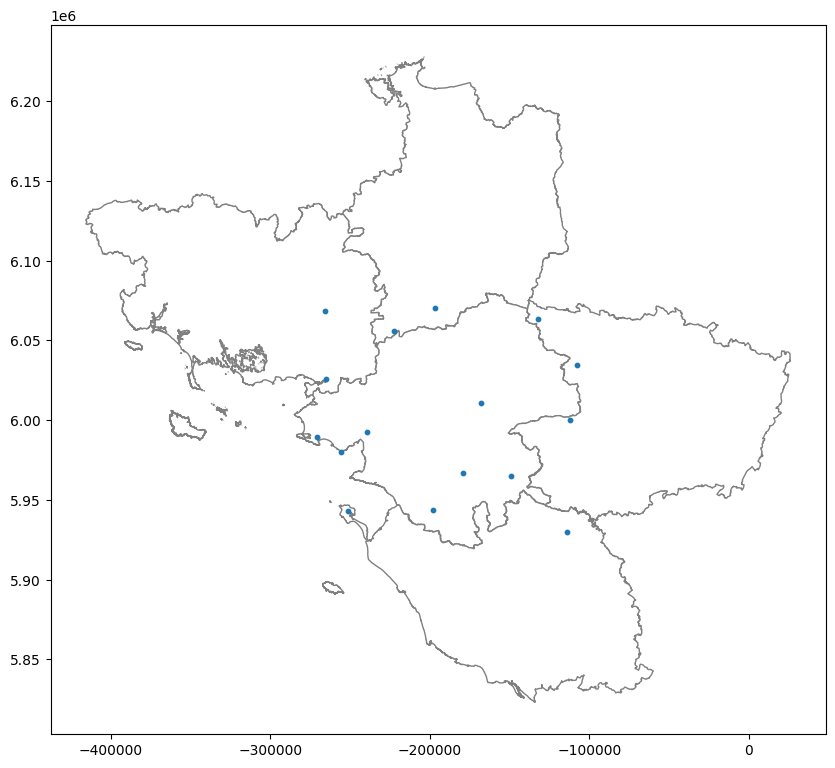

In [17]:
depts = ['ILLE-ET-VILAINE', 'LOIRE-ATLANTIQUE', 'MAINE-ET-LOIRE', 'MORBIHAN', 'VENDEE']
region = mapcom.loc[mapcom['nom_m'].isin(depts)]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
region.plot(ax=ax, color='white', edgecolor='gray')

gdf_raw_LA = gpd.GeoDataFrame(df_sub_height, geometry=gpd.points_from_xy(df_sub_height.lon, df_sub_height.lat)).set_crs('EPSG:4326')
gdf_raw_LA = gdf_raw_LA.to_crs(epsg=3857)
gdf_raw_LA.plot(ax=ax, markersize=10, legend=True)

To compare, we plot the selected stations with our previous visualization function using plotly. The results are consistent, even if the INSEE map is lighter, which make it more understandable in my point of view...

In [18]:
plot_location_height(df_raw_LA, zoom=6)

# TODO :
- plot ApdL stations on INSEE map
- add height parameter 

- start processing meteo data via ML models. But this is maybe for another notebook...